In [1]:
import tensorflow as tf
from tensorflow.contrib.model_pruning.python import pruning
from tensorflow.contrib.model_pruning.python.layers import layers
import keras
from utils import *
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# session = tf.Session(config=config)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
epochs = 50
epochs_prune = 5
batch_size = 200
model_path_unpruned = "Model_Saves/Unpruned_{}.ckpt"
model_path_pruned = "Model_Saves/Pruned_{}.ckpt"
NUM_CLASS = 10
batch_size_test = batch_size

In [4]:
#Load Dataset
X_train0, y_train = prepare_dataset(data_dir, 'train')
X_test0, y_test = prepare_dataset(data_dir, 'test')
t = int(time.time())

#Normalizing
mean = np.mean(X_train0,axis=(0,1,2,3))
std = np.std(X_train0,axis=(0,1,2,3))
np.save('mean',mean)
np.save('std',std)
X_train = z_normalization(X_train0, mean, std)
X_test = z_normalization(X_test0, mean, std)

#Labels to binary
y_train_binary = keras.utils.to_categorical(y_train,num_classes)
y_test_binary = keras.utils.to_categorical(y_test,num_classes)

Loading numpy
Loading numpy


In [5]:
batches = int(len(X_train) / batch_size)
batches_test = int(len(X_test) / batch_size_test)
print(batches)
print(batches_test)

250
50


In [6]:
def sample_batch(dataset, labels, batch_size):
    N = dataset.shape[0]
    indices = np.random.randint(N, size=batch_size)
    x_epoch = dataset[indices]
    y_epoch = labels[indices]
    return x_epoch, y_epoch

def test_batch(dataset, labels, batch_size):
    for index, offset in enumerate(range(0, dataset.shape[0], batch_size)):
        x_epoch, y_epoch = np.array(dataset[offset: offset + batch_size,:]), np.array(labels[offset: offset +  batch_size])
    return x_epoch, y_epoch

In [7]:
tf.reset_default_graph()

image = tf.placeholder(name='images', dtype=tf.float32, shape=[None, 32, 32, 3])
label = tf.placeholder(name='fine_labels', dtype=tf.int32, shape=[None, 10])

_=image
_ = layers.masked_conv2d(_, 96, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm1-1')
_ = layers.masked_conv2d(_, 96, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm1-2')
_ = tf.layers.max_pooling2d(_, (3, 3), 2, 'SAME',name='pool1')
_ = layers.masked_conv2d(_, 192, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm2-1')
_ = layers.masked_conv2d(_, 192, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm2-2')
_ = tf.layers.max_pooling2d(_, (3, 3), 2, 'SAME', name='pool2')
_ = layers.masked_conv2d(_, 192, (3, 3), 1, 'VALID')
_ = tf.layers.batch_normalization(_, name='norm3')
_ = layers.masked_conv2d(_, 192, (1, 1), 1)
_ = tf.layers.batch_normalization(_, name='norm4')
_ = layers.masked_conv2d(_, 10, (1, 1), 1)
_ = tf.layers.batch_normalization(_, name='norm5')
_ = tf.layers.average_pooling2d(_, (6,6), 1, name='avg_pool')
y = _
logits = tf.reshape(y,[tf.shape(y)[0],10])


# Create global step variable (needed for pruning)
global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

# Loss function

loss = tf.losses.softmax_cross_entropy(label, logits)

# Training op, the global step is critical here, make sure it matches the one used in pruning later
# running this operation increments the global_step
train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)

# Accuracy ops
prediction = tf.cast(tf.argmax(logits, axis=1), tf.int32)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_5 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(predictions=logits, targets=tf.argmax(label, 1), k=5), tf.float32))


In [8]:
# Get, Print, and Edit Pruning Hyperparameters
def set_prune_params(s):
    pruning_hparams = pruning.get_pruning_hparams()
    print("Pruning Hyperparameters:", pruning_hparams)

    # Change hyperparameters to meet our needs
    pruning_hparams.begin_pruning_step = 0
    pruning_hparams.end_pruning_step = 250
    pruning_hparams.pruning_frequency = 1
    pruning_hparams.sparsity_function_end_step = 250
    pruning_hparams.target_sparsity = s

    # Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
    p = pruning.Pruning(pruning_hparams, global_step=global_step) #sparsity=.5)
    prune_op = p.conditional_mask_update_op()
    return prune_op

# Create a saver for writing training checkpoints.
saver = tf.train.Saver(max_to_keep=100)



In [10]:
with tf.Session() as sess:
    
    acc = 0
    # Global initializer
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, model_path_unpruned.format('best'))
    
    # Train the model before pruning (optional)
    for epoch in range(epochs):
        for batch in range(batches):
            batch_xs, batch_ys = sample_batch(X_train, y_train_binary, batch_size)
            sess.run(train_op, feed_dict={image: batch_xs, label: batch_ys})

        # Calculate Test Accuracy every 5 epochs
        if (epoch+1) % 2 == 0:
            acc_print = 0
            acc_print_5 = 0
            for index, offset in enumerate(range(0, X_test.shape[0], batch_size_test)):
                batch_xt = np.array(X_test[offset: offset + batch_size_test,:]) 
                batch_yt = np.array(y_test_binary[offset: offset +  batch_size_test])
                acc_print += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
                acc_print_5 += sess.run(accuracy_5, feed_dict={image: batch_xt, label: batch_yt})
            acc_print = acc_print/batches_test
            acc_print_5 = acc_print_5/batches_test
            print("Un-pruned model epoch %d test accuracy %g" % (epoch+1, acc_print))
            print("Un-pruned model epoch %d test top5-accuracy %g" % (epoch+1, acc_print_5))
            
            # Saves the model before pruning
            if acc_print>acc:
                acc =acc_print
                print('saving')
                saver.save(sess, model_path_unpruned.format('best'))
        print(epoch+1)
    saver.save(sess, model_path_unpruned.format('final'))    

1
Un-pruned model epoch 2 test accuracy 0.6914
Un-pruned model epoch 2 test top5-accuracy 0.9778
saving
2
3
Un-pruned model epoch 4 test accuracy 0.7854
Un-pruned model epoch 4 test top5-accuracy 0.9887
saving
4
5
Un-pruned model epoch 6 test accuracy 0.8115
Un-pruned model epoch 6 test top5-accuracy 0.9912
saving
6
7
Un-pruned model epoch 8 test accuracy 0.8112
Un-pruned model epoch 8 test top5-accuracy 0.9913
8
9
Un-pruned model epoch 10 test accuracy 0.8298
Un-pruned model epoch 10 test top5-accuracy 0.9923
saving
10
11
Un-pruned model epoch 12 test accuracy 0.8273
Un-pruned model epoch 12 test top5-accuracy 0.9915
12
13
Un-pruned model epoch 14 test accuracy 0.8295
Un-pruned model epoch 14 test top5-accuracy 0.9918
14
15
Un-pruned model epoch 16 test accuracy 0.8292
Un-pruned model epoch 16 test top5-accuracy 0.9926
16
17
Un-pruned model epoch 18 test accuracy 0.8307
Un-pruned model epoch 18 test top5-accuracy 0.9921
saving
18
19
Un-pruned model epoch 20 test accuracy 0.8382
Un-pru

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path_unpruned.format('best'))
    acc_print = 0
    acc_print_5 = 0
    for index, offset in enumerate(range(0, X_test.shape[0], batch_size)):
        batch_xt = np.array(X_test[offset: offset + batch_size,:]) 
        batch_yt = np.array(y_test_binary[offset: offset +  batch_size])
        acc_print += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
        acc_print_5 += sess.run(accuracy_5, feed_dict={image: batch_xt, label: batch_yt})
    acc_print = acc_print/batches_test
    acc_print_5 = acc_print_5/batches_test
    print("Un-pruned model epoch %d test accuracy %g" % (1, acc_print))
    print("Un-pruned model epoch %d test top5-accuracy %g" % (1, acc_print_5))
    print("Sparsity of layers (should be 0)", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
Un-pruned model epoch 1 test accuracy 0.8413
Un-pruned model epoch 1 test top5-accuracy 0.9924
Sparsity of layers (should be 0) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
sparsity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [11]:
acc = []
acc_5 = []
for s in sparsity:
    prune_op = set_prune_params(s)
    print('Target sparsity is {}'.format(s))
    
    with tf.Session() as sess:
        # Resets the session and restores the saved model
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_path_unpruned.format('best'))

        # Reset the global step counter and begin pruning
        sess.run(reset_global_step_op)
        for epoch in range(epochs_prune):
            for batch in range(batches):
                batch_xs, batch_ys = sample_batch(X_train, y_train_binary, batch_size)
                # Prune and retrain
                sess.run(prune_op)
                sess.run(train_op, feed_dict={image: batch_xs, label: batch_ys})

            # Calculate Test Accuracy every epoch
            #if (epoch+1) % 1 == 0:
            acc_print = 0
            acc_print_5 = 0
            for index, offset in enumerate(range(0, X_test.shape[0], batch_size)):
                batch_xt = np.array(X_test[offset: offset + batch_size,:]) 
                batch_yt = np.array(y_test_binary[offset: offset +  batch_size])
                acc_print += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
                acc_print_5 += sess.run(accuracy_5, feed_dict={image: batch_xt, label: batch_yt})
            acc.append(acc_print/batches_test)
            acc_5.append(acc_print_5/batches_test)
            print(epoch) 
            print("Pruned model step %d test accuracy %g" % (epoch, acc_print/batches_test))
            print("Pruned model step %d test top5-accuracy %g" % (epoch, acc_print_5/batches_test))
            print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
            

        # Saves the model after pruning
        saver.save(sess, model_path_pruned.format(s))

        # Print final accuracy
        #acc_print = sess.run(accuracy, feed_dict={image: mnist.test.images, label: mnist.test.labels})
        print("Final accuracy:", acc_print/batches_test)
        print("Final sparsity by layer", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

Pruning Hyperparameters: [('begin_pruning_step', 0), ('block_height', 1), ('block_pooling_function', 'AVG'), ('block_width', 1), ('end_pruning_step', -1), ('initial_sparsity', 0), ('name', 'model_pruning'), ('nbins', 256), ('pruning_frequency', 10), ('sparsity_function_begin_step', 0), ('sparsity_function_end_step', 100), ('sparsity_function_exponent', 3), ('target_sparsity', 0.5), ('threshold_decay', 0.9), ('use_tpu', False), ('weight_sparsity_map', [''])]
INFO:tensorflow:Updating masks.
Target sparsity is 0.1
INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
0
Pruned model step 0 test accuracy 0.8375
Pruned model step 0 test top5-accuracy 0.9904
Weight sparsities: [0.099922836, 0.09684847, 0.1003207, 0.096926846, 0.096773125, 0.0981174, 0.09947917]
1
Pruned model step 1 test accuracy 0.8297
Pruned model step 1 test top5-accuracy 0.9912
Weight sparsities: [0.099922836, 0.097017266, 0.094853155, 0.09740608, 0.09696301, 0.09825304, 0.09947917]
2
Pruned model step 

Final accuracy: 0.8550000011920929
Final sparsity by layer [0.4996142, 0.49537036, 0.49675685, 0.4910723, 0.49390855, 0.49723306, 0.49895832]
Pruning Hyperparameters: [('begin_pruning_step', 0), ('block_height', 1), ('block_pooling_function', 'AVG'), ('block_width', 1), ('end_pruning_step', -1), ('initial_sparsity', 0), ('name', 'model_pruning'), ('nbins', 256), ('pruning_frequency', 10), ('sparsity_function_begin_step', 0), ('sparsity_function_end_step', 100), ('sparsity_function_exponent', 3), ('target_sparsity', 0.5), ('threshold_decay', 0.9), ('use_tpu', False), ('weight_sparsity_map', [''])]
INFO:tensorflow:Updating masks.
Target sparsity is 0.6
INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
0
Pruned model step 0 test accuracy 0.8432
Pruned model step 0 test top5-accuracy 0.9914
Weight sparsities: [0.59992284, 0.594172, 0.59575135, 0.59686357, 0.59488934, 0.5987956, 0.59739584]
1
Pruned model step 1 test accuracy 0.8518
Pruned model step 1 test top5-accur

Final accuracy: 0.7747000014781952
Final sparsity by layer [0.9498457, 0.95005065, 0.9500265, 0.9495292, 0.94949603, 0.9495714, 0.94895834]
Pruning Hyperparameters: [('begin_pruning_step', 0), ('block_height', 1), ('block_pooling_function', 'AVG'), ('block_width', 1), ('end_pruning_step', -1), ('initial_sparsity', 0), ('name', 'model_pruning'), ('nbins', 256), ('pruning_frequency', 10), ('sparsity_function_begin_step', 0), ('sparsity_function_end_step', 100), ('sparsity_function_exponent', 3), ('target_sparsity', 0.5), ('threshold_decay', 0.9), ('use_tpu', False), ('weight_sparsity_map', [''])]
INFO:tensorflow:Updating masks.
Target sparsity is 0.99
INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
0
Pruned model step 0 test accuracy 0.3004
Pruned model step 0 test top5-accuracy 0.7496
Weight sparsities: [0.98919755, 0.98952305, 0.9894146, 0.98950195, 0.9895713, 0.9895291, 0.9895833]
1
Pruned model step 1 test accuracy 0.3962
Pruned model step 1 test top5-accurac

In [13]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
print_tensors_in_checkpoint_file('Model_Saves/Unpruned44.ckpt', 
                                 all_tensors=False, all_tensor_names=False, tensor_name='')

Conv/biases (DT_FLOAT) [96]
Conv/biases/Adam (DT_FLOAT) [96]
Conv/biases/Adam_1 (DT_FLOAT) [96]
Conv/mask (DT_FLOAT) [3,3,3,96]
Conv/threshold (DT_FLOAT) []
Conv/weights (DT_FLOAT) [3,3,3,96]
Conv/weights/Adam (DT_FLOAT) [3,3,3,96]
Conv/weights/Adam_1 (DT_FLOAT) [3,3,3,96]
Conv_1/biases (DT_FLOAT) [96]
Conv_1/biases/Adam (DT_FLOAT) [96]
Conv_1/biases/Adam_1 (DT_FLOAT) [96]
Conv_1/mask (DT_FLOAT) [3,3,96,96]
Conv_1/threshold (DT_FLOAT) []
Conv_1/weights (DT_FLOAT) [3,3,96,96]
Conv_1/weights/Adam (DT_FLOAT) [3,3,96,96]
Conv_1/weights/Adam_1 (DT_FLOAT) [3,3,96,96]
Conv_2/biases (DT_FLOAT) [192]
Conv_2/biases/Adam (DT_FLOAT) [192]
Conv_2/biases/Adam_1 (DT_FLOAT) [192]
Conv_2/mask (DT_FLOAT) [3,3,96,192]
Conv_2/threshold (DT_FLOAT) []
Conv_2/weights (DT_FLOAT) [3,3,96,192]
Conv_2/weights/Adam (DT_FLOAT) [3,3,96,192]
Conv_2/weights/Adam_1 (DT_FLOAT) [3,3,96,192]
Conv_3/biases (DT_FLOAT) [192]
Conv_3/biases/Adam (DT_FLOAT) [192]
Conv_3/biases/Adam_1 (DT_FLOAT) [192]
Conv_3/mask (DT_FLOAT) [3,

In [21]:
print_tensors_in_checkpoint_file('Model_Saves/Unpruned44.ckpt', 
                                 all_tensors=False, all_tensor_names=False, tensor_name='Conv/weights')

tensor_name:  Conv/weights
[[[[ 0.04379602 -0.05505071 -0.08778767 ...  0.03066595 -0.04357576
    -0.05353526]
   [ 0.0070363   0.04169472 -0.0729975  ...  0.08931225 -0.06831206
     0.10006074]
   [ 0.12743428  0.07768662  0.0874206  ... -0.02181112 -0.04949465
     0.09114436]]

  [[-0.0539235  -0.03097104  0.01627925 ...  0.05563014 -0.09813255
     0.1472321 ]
   [ 0.00965081  0.02887369  0.01724323 ... -0.02030833 -0.11718856
     0.07390618]
   [ 0.08303585 -0.03235126  0.12467189 ... -0.1112793   0.02824809
     0.08702562]]

  [[-0.15823641 -0.06146544  0.00619495 ...  0.031168    0.04163508
     0.13076901]
   [-0.11911135  0.11352054 -0.05747633 ...  0.02983151 -0.07704147
     0.10038877]
   [-0.01146747  0.01727173  0.14272916 ...  0.06176776  0.0394776
     0.03551508]]]


 [[[ 0.04224705  0.04160998 -0.02847889 ... -0.11748441 -0.06114323
     0.15397218]
   [ 0.06881077  0.05409041 -0.01212053 ... -0.13167563 -0.11558327
    -0.02307469]
   [-0.05883789 -0.02132129  0.

In [33]:
with tf.Session() as sess1:
    sess1.run("Conv/weights")

In [16]:
vars = tf.trainable_variables()
print(vars) #some infos about variables...

[<tf.Variable 'Conv/weights:0' shape=(3, 3, 3, 96) dtype=float32_ref>, <tf.Variable 'Conv/biases:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'norm1-1/gamma:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'norm1-1/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Conv_1/weights:0' shape=(3, 3, 96, 96) dtype=float32_ref>, <tf.Variable 'Conv_1/biases:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'norm1-2/gamma:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'norm1-2/beta:0' shape=(96,) dtype=float32_ref>, <tf.Variable 'Conv_2/weights:0' shape=(3, 3, 96, 192) dtype=float32_ref>, <tf.Variable 'Conv_2/biases:0' shape=(192,) dtype=float32_ref>, <tf.Variable 'norm2-1/gamma:0' shape=(192,) dtype=float32_ref>, <tf.Variable 'norm2-1/beta:0' shape=(192,) dtype=float32_ref>, <tf.Variable 'Conv_3/weights:0' shape=(3, 3, 192, 192) dtype=float32_ref>, <tf.Variable 'Conv_3/biases:0' shape=(192,) dtype=float32_ref>, <tf.Variable 'norm2-2/gamma:0' shape=(192,) dtype=float32_ref>, <tf.Variable '

In [20]:
thresh = [] 
pruned = []
with tf.Session() as sess:
    # Resets the session and restores the saved model
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, model_path_unpruned.format(44))
    saver.restore(sess, model_path_pruned.format(0.9))
    # get the graph
    g = tf.get_default_graph()
    for i in range(7):
        if (i==0):
            t = g.get_tensor_by_name('Conv/threshold:0')
            m = g.get_tensor_by_name('Conv/mask:0')

        else:
            t = g.get_tensor_by_name('Conv_{}/threshold:0'.format(i))
            m = g.get_tensor_by_name('Conv_{}/mask:0'.format(i))
            
        x = sess.run(t)
        y = sess.run(m)
        thresh.append(x)
        pruned.append(np.count_nonzero(y==0))

INFO:tensorflow:Restoring parameters from Model_Saves/Pruned_0.9.ckpt


In [88]:
acc[4:55:5]

[0.834599996805191,
 0.8163999998569489,
 0.8406000065803528,
 0.855699998140335,
 0.8550000011920929,
 0.8522000002861023,
 0.8546000015735626,
 0.8416000020503998,
 0.8269999957084656,
 0.7747000014781952,
 0.5044999951124192]

In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


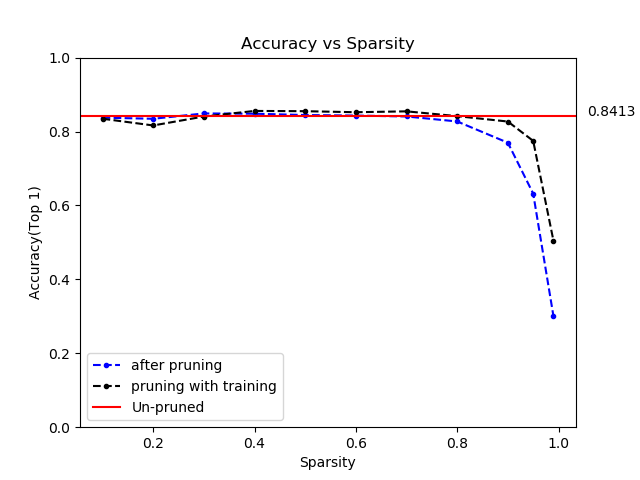

<IPython.core.display.Javascript object>


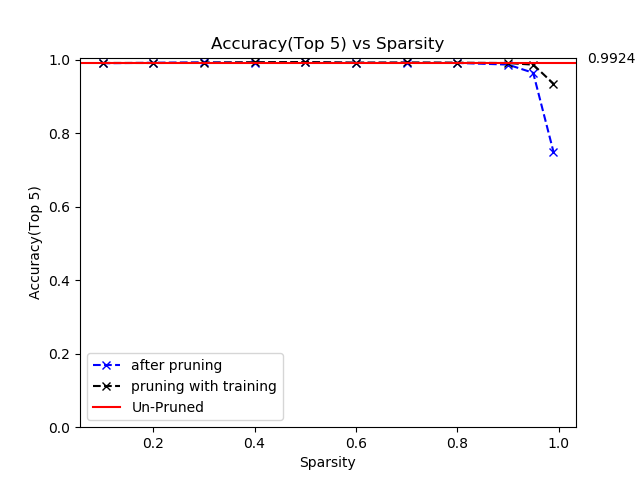

In [87]:
plt.figure()
plt.plot(sparsity, acc[0:55:5], 'b--.', label='after pruning')
plt.plot(sparsity, acc[4:55:5], 'k--.', label='pruning with training')
plt.axhline(y=0.8413, color='r', linestyle='-', label = 'Un-pruned')
plt.annotate('0.8413', xy=(1, 0.8413), xytext=(8, 0), 
             xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy(Top 1)')
plt.ylim(bottom=0, top=1) 
plt.legend(loc = 3)
plt.show()

plt.figure()
plt.plot(sparsity, acc_5[0:55:5], 'b--x', label='after pruning')
plt.plot(sparsity, acc_5[4:55:5], 'k--x', label='pruning with training')
plt.axhline(y=0.9924, color='r', linestyle='-', label = 'Un-Pruned')
plt.annotate('0.9924', xy=(1, 0.9924), xytext=(8, 0), 
             xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.title('Accuracy(Top 5) vs Sparsity')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy(Top 5)')
plt.ylim(bottom=0) 
plt.legend(loc = 3)
plt.show()

In [15]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parametes = 1
    for dim in shape:
        variable_parametes *= dim.value
    total_parameters += variable_parametes
print("Total training params: %.5fM" % (total_parameters / 1e6))

Total training params: 0.95667M


In [47]:
with tf.Session() as sess:
    # Resets the session and restores the saved model
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path_pruned.format(0.9))
    tvars = tf.trainable_variables()
    tvars_vals = sess.run(tvars)

    for var, val in zip(tvars, tvars_vals):
        print(var.name, val)

INFO:tensorflow:Restoring parameters from Model_Saves/Pruned0.9.ckpt
Conv/weights:0 [[[[ 0.04386877 -0.05370045 -0.08818778 ...  0.03163777 -0.03516616
    -0.05234836]
   [ 0.00367678  0.03967545 -0.07397655 ...  0.08231409 -0.06926255
     0.09879471]
   [ 0.12032126  0.06689382  0.08355619 ... -0.02391103 -0.04284841
     0.09426026]]

  [[-0.0479385  -0.02921759  0.01969598 ...  0.05949609 -0.08868785
     0.24975243]
   [ 0.00721393  0.03141775  0.01831823 ... -0.01895187 -0.12521599
     0.07258015]
   [ 0.07973339 -0.03227412  0.14145286 ... -0.10893171  0.03382431
     0.09231466]]

  [[-0.14586031 -0.06017137  0.00895014 ...  0.03246674  0.05327276
     0.13533467]
   [-0.1040989   0.0871282  -0.05544589 ...  0.03138801 -0.06712543
     0.11880873]
   [-0.01569531  0.01624121  0.19445866 ...  0.06390522  0.04735205
     0.03824019]]]


 [[[ 0.0377103   0.03618093 -0.02557194 ... -0.10170904 -0.05498583
     0.1387983 ]
   [ 0.06660452  0.05048921 -0.01265561 ... -0.14740188 -0

In [ ]:
with tf.Session() as sess:
    tvars = tf.trainable_variables()
    for var in tvars:
        if var.name.endswith('weights:0'):
            val = sess.run(var)
            print(var.name, val)

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path_unpruned.format('best'))
    converter = tf.contrib.lite.TFLiteConverter.from_session(sess, [image], [logits])
    tflite_model = converter.convert()
    open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
INFO:tensorflow:Froze 49 variables.
INFO:tensorflow:Converted 49 variables to const ops.


In [17]:
# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data = np.array(np.expand_dims(X_test[0], axis=0), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[ 7.082089 13.164969  6.190519 28.866556  6.95079  19.646297 18.500494
   8.627177 10.947189  6.516569]]


In [18]:
# Test model on test data.
#input_shape = input_details[0]['shape']
acc = 0
y_pred = []
for i,img in enumerate(X_test):
    print(i)
    input_data = np.array(np.expand_dims(img, axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    #print(output_data)
    y_pred.append(np.argmax(output_data, axis=1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082


3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735


5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374


6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029


8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677


In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8354


In [20]:
input_details

[{'name': 'images',
  'index': 24,
  'shape': array([ 1, 32, 32,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [21]:
output_details

[{'name': 'Reshape',
  'index': 21,
  'shape': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [ ]:
epochs = 3
batch_size = 512 # Entire training set
model_path_unpruned = "Model_Saves/Unpruned.ckpt"
model_path_pruned = "Model_Saves/Pruned.ckpt"
NUM_CLASS = 10
tf.reset_default_graph()

# Import dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
batches = int(len(mnist.train.images) / batch_size)

# Define Placeholders
# image = tf.placeholder(tf.float32, [None, 28,28])
# label = tf.placeholder(tf.float32, [None, 10])

image = tf.placeholder(name='images', dtype=tf.float32, shape=[None, 28, 28, 1])
label = tf.placeholder(name='fine_labels', dtype=tf.int32, shape=[None,10])

# # Define the model
# layer1 = layers.masked_fully_connected(image, 300)
# layer2 = layers.masked_fully_connected(layer1, 300)
# logits = layers.masked_fully_connected(layer2, 10)

# Define the model
# layer1 = layers.masked_conv2d(image, 300, kernel_size=2)
# layer2 = layers.masked_conv2d(layer1, 300, kernel_size=2)
# logits = layers.masked_fully_connected(layer2, 10)

_=image
_ = layers.masked_conv2d(_, 96, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm1-1')
_ = layers.masked_conv2d(_, 96, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm1-2')
_ = tf.layers.max_pooling2d(_, (3, 3), 2, 'SAME',name='pool1')
_ = layers.masked_conv2d(_, 192, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm2-1')
_ = layers.masked_conv2d(_, 192, (3, 3), 1, 'SAME')
_ = tf.layers.batch_normalization(_, name='norm2-2')
_ = tf.layers.max_pooling2d(_, (3, 3), 2, 'SAME', name='pool2')
_ = layers.masked_conv2d(_, 192, (3, 3), 1, 'VALID')
_ = tf.layers.batch_normalization(_, name='norm3')
_ = layers.masked_conv2d(_, 192, (1, 1), 1)
_ = tf.layers.batch_normalization(_, name='norm4')
_ = layers.masked_conv2d(_, 10, (1, 1), 1)
_ = tf.layers.batch_normalization(_, name='norm5')
_ = tf.layers.average_pooling2d(_, (5,5), 1, name='avg_pool')
y = _
logits = tf.reshape(y,[tf.shape(y)[0],10])


# Create global step variable (needed for pruning)
global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

# Loss function
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=label))
#loss = tf.losses.softmax_cross_entropy(tf.one_hot(label, NUM_CLASS), logits)
loss = tf.losses.softmax_cross_entropy(label, logits)

# Training op, the global step is critical here, make sure it matches the one used in pruning later
# running this operation increments the global_step
train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

# Accuracy ops
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [ ]:
# Get, Print, and Edit Pruning Hyperparameters
pruning_hparams = pruning.get_pruning_hparams()
print("Pruning Hyperparameters:", pruning_hparams)

# Change hyperparameters to meet our needs
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 250
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 250
pruning_hparams.target_sparsity = .5

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step) #sparsity=.5)
prune_op = p.conditional_mask_update_op()

# Create a saver for writing training checkpoints.
saver = tf.train.Saver()



In [ ]:
with tf.Session() as sess:

    # Uncomment the following if you don't have a trained model yet
    sess.run(tf.global_variables_initializer())

    # Train the model before pruning (optional)
    for epoch in range(epochs):
        for batch in range(batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            #print(batch_xs.shape)
            batch_xs = batch_xs.reshape(-1,28,28,1)
            sess.run(train_op, feed_dict={image: batch_xs, label: batch_ys})

        # Calculate Test Accuracy every 10 epochs
        if epoch % 1 == 0:
            acc_print = 0
            for batch in range(batches):
                batch_xt, batch_yt = mnist.test.next_batch(batch_size)
                #print(batch_xt.shape)
                batch_xt = batch_xt.reshape(-1,28,28,1)
                acc_print += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
            print("Un-pruned model step %d test accuracy %g" % (epoch, acc_print/batches))
        print(epoch)
    
    # Saves the model before pruning
    saver.save(sess, model_path_unpruned)
    
    acc_print = sess.run(accuracy, feed_dict={image: mnist.test.images.reshape(-1,28,28,1), label: mnist.test.labels})
    print("Pre-Pruning accuracy:", acc_print)
    print("Sparsity of layers (should be 0)", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    

    # Resets the session and restores the saved model
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, model_path_unpruned)

    # Reset the global step counter and begin pruning
    sess.run(reset_global_step_op)
    for epoch in range(epochs):
        for batch in range(batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            batch_xs = batch_xs.reshape(-1,28,28,1)
            # Prune and retrain
            sess.run(prune_op)
            sess.run(train_op, feed_dict={image: batch_xs, label: batch_ys})

        # Calculate Test Accuracy every 10 epochs
        if epoch % 1 == 0:
            acc_print = 0
            for batch in range(batches):
                batch_xt, batch_yt = mnist.test.next_batch(batch_size)
                #print(batch_xt.shape)
                batch_xt = batch_xt.reshape(-1,28,28,1)
                acc_print += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
            
            print("Pruned model step %d test accuracy %g" % (epoch, acc_print/batches))
            print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
        print(epoch) 
        
           # acc_print = sess.run(accuracy, feed_dict={image: mnist.test.images, label: mnist.test.labels})

    # Saves the model after pruning
    saver.save(sess, model_path_pruned)

    # Print final accuracy
    #acc_print = sess.run(accuracy, feed_dict={image: mnist.test.images, label: mnist.test.labels})
    print("Final accuracy:", acc_print)
    print("Final sparsity by layer (should be 0)", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

In [ ]:
mnist

In [ ]:
batches